# Machine Learning Group Project - Group 50
## Masters in Data Science and Advanced Analytics at NOVA IMS, Lisbon

## Group Information
Group members: **<span style="color:red">(Everyone please check and correct the names)</span><br>**
Md. Shawkatul Islam Aziz<br>
Md. Tahir Hossain<br>
Philipp Metzger<br>
Ali Sabbir<br>
Henrique Vaz<br>

## Import all libraries needed

In [1]:
import os
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

In [2]:
train = pd.read_excel(os.path.join('Data', 'Train.xlsx'), sheet_name='Sheet1')
test = pd.read_excel(os.path.join('Data', 'Test.xlsx'), sheet_name='Sheet1')

## First exploration of the training set

In [3]:
# Show the first three rows of 'train'
train.head(3)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


In [4]:
# Get the dimensions of 'train'
train.shape

(22400, 15)

In [5]:
# Check the data types and check if there are missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [6]:
# Get the basic descriptive statistics on 'train'
train.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


## Transform 'Birthday' to datetime format and get the age in days relative to today

In [7]:
# Define a function that maps month names to their integers

def monthToInt(monthStr):

    return {
            'January' : 1,
            'February' : 2,
            'March' : 3,
            'April' : 4,
            'May' : 5,
            'June' : 6,
            'July' : 7,
            'August' : 8,
            'September' : 9, 
            'October' : 10,
            'November' : 11,
            'December' : 12
    }[monthStr]

In [8]:
# Define a function that checks if a year is a leap year
# Adapted from:
# https://www.programiz.com/python-programming/examples/leap-year

# "A leap year is exactly divisible by 4 except for century years (years ending with 00). 
# The century year is a leap year only if it is perfectly divisible by 400."

def is_leapyear(year):
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

In [9]:
# Define a function that takes uses the information from column 'Birthday' and adds a column that contains the
# birthdays as datetime objects and another column that contains the age of the person in days relative to today (2020)

def add_Birthday_date_Age_days_rel_to_2020(df):
    
    # Make a copy
    df_copy = df.copy()
    
    # Get the year, month and day from Strings in 'Birthday'
    split = df_copy.Birthday.str.split(',', expand=True)
    year = split.iloc[:,1].astype(int)
    month_day = split.iloc[:,0].str.strip(to_strip=' ').str.split(' ', expand=True)
    day = month_day.iloc[:,1].astype(int)
    month = month_day.iloc[:,0]
    
    # Map month names to integers
    month = month.map(lambda x:monthToInt(x))
    
    # Build a dataframe containing the date values
    frame = {'year':year, 'month':month, 'day':day}
    birthday = pd.DataFrame(frame)
    
    # Create datetime objects from the date values
    # Some problems with leap years (see below)
    birthday_date = []
    for i in range(birthday.shape[0]):
    
        # Get the values for this row
        year_i = int(birthday.iloc[i,0])
        month_i = int(birthday.iloc[i,1])
        day_i = int(birthday.iloc[i,2])

        # Leap years are incorrectly defined for this dataset.
        # For example row 359: year 2022, month 2, day 29 is a birthday in this datase, but in reality it does not exist.
        # -> Decrease all days where month=2 and day=29 that aren't in a leap year by 1 day to be able to use 
        # datetime.date

        # Get True if this year is a leap year, else False
        leapyear = is_leapyear(year_i)

        if (~leapyear and month_i==2 and day_i==29):
            day_i = day_i - 1
        date = datetime.date(year_i, month_i, day_i)
        birthday_date.append(date)
        
    # Convert the list to a pandas series
    birthday_date = pd.Series(birthday_date)
    
    # Insert 'birthday_date' as new column 'Birthday_date'
    df_copy.insert(loc=3, column='Birthday_date', value=birthday_date)
    
    # Compute time differences to today (2020) and keep only the value in days
    now = date.today()
    age = now - df_copy.Birthday_date
    age_days = age.dt.days
    
    # Insert 'age_days' as 'Age_days_rel_to_2020'
    df_copy.insert(loc=4, column='Age_days_rel_to_2020', value=age_days)
    
    # Return the resulting dataframe
    return df_copy

In [10]:
# Use the function defined above to add columns 'Birthday_date' and 'Age_days_rel_to_2020' to 'train'
train_new_cols = add_Birthday_date_Age_days_rel_to_2020(train)

In [11]:
# Check the result
train_new_cols.head(3)

,CITIZEN_ID,Name,Birthday,Birthday_date,Age_days_rel_to_2020,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",2003-07-01,6353,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",2006-01-25,5414,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",2009-05-10,4213,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


## Compute and visualise the correlations between the metric features and the target

In [12]:
# Define metric features and target in one list
metric_features_and_target = ['Age_days_rel_to_2020','Years of Education','Working Hours per week','Money Received','Ticket Price','Income']

In [13]:
# Compute the correlation matrix of 'train'
corr = train_new_cols[metric_features_and_target].corr(method='pearson')

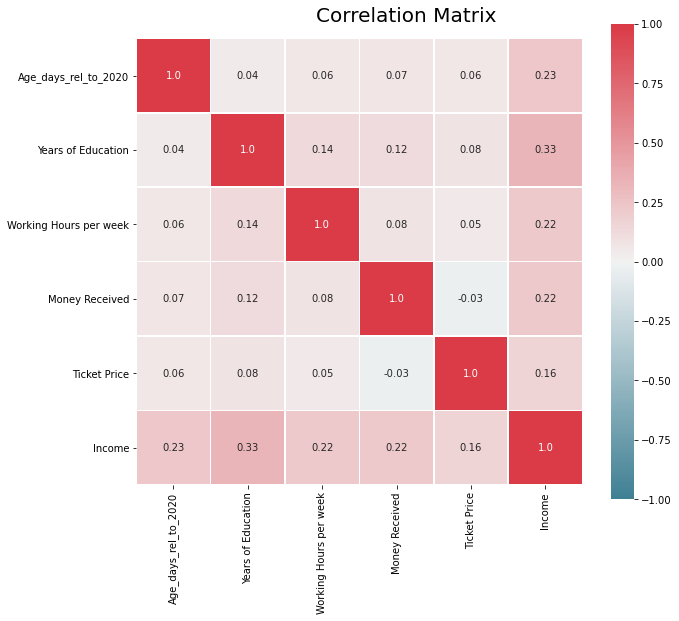

In [14]:
# Adapted from data mining lab 4:

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Round the values of the correlation matrix
corr_rounded = np.round(corr, decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr_rounded.values) >= 0.001
annot = np.where(mask_annot, corr_rounded.values, np.full(corr_rounded.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr_rounded, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()